Lesson 5 - Applied Regression Modeling - Solutions

In [1]:
import pandas as pd
import numpy as np
import os

from bs4 import BeautifulSoup
import urllib.request
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

# In this exercise we will be using data from the National Football League (NFL) to determine if data on rushing yards in 2018 can predict the outcome of rushing in 2019. 

We have player stats data that is scraped from the following online sources
- https://www.nfl.com/stats/player-stats/
- https://www.nfl.com/players/

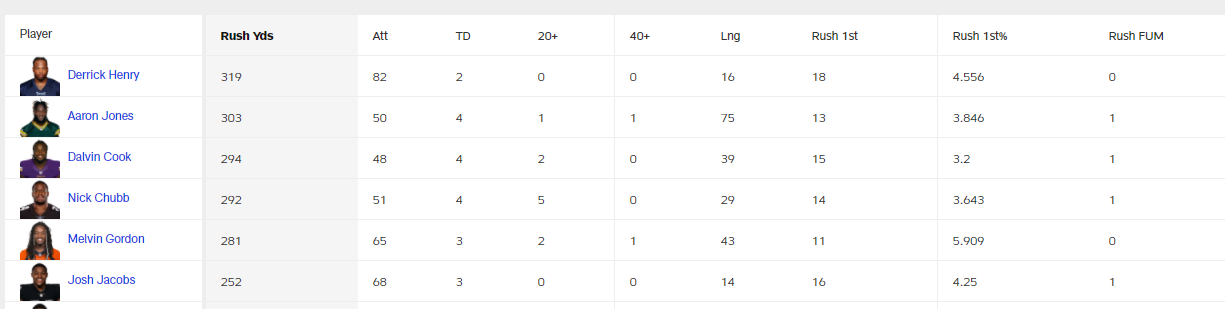

# NFL Directory Functions

In [2]:
def find_next_url(url, keyword):

    links = []
    parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))

    for link in soup.find_all('a', href=True):
        links.append(link['href'])

    next_url = 'https://www.nfl.com'+str([link for link in links if str(keyword) in link][0])
    
    return next_url

In [3]:
def get_players(url, players, letter, keyword):

    #print('Downloading players with last names starting with {} at url: {}'.format(letter, url))
    download = pd.read_html(url)[0]
    objs = [players,download]
    players = pd.concat(objs, axis=0, join='outer', 
                        ignore_index=False, keys=None, levels=None, 
                        names=None, verify_integrity=False, copy=True)    

    # NOTE: recursively iterates to the next URL at the bottom of the page.
    try:
        next_url = find_next_url(url, keyword)
        
        if next_url == 'https://www.nfl.com/players/active/{}?query={}&after='.format(letter,letter):
            return players
        
        else: 
            url = next_url
            players = get_players(url, players, letter, keyword)
        
    except:
        return players
    
    return players

In [4]:
def get_nfl_player_directory(save_to_pickle = True):

    players = pd.DataFrame()

    for letter in [chr(x) for x in range(ord('a'), ord('z') + 1)]:

        #primary url
        url = 'https://www.nfl.com/players/active/{}'.format(letter)
        keyword = 'after'
        players = get_players(url, players, letter, keyword)
    
    if save_to_pickle:
        
        # Save as a pickle file
        players.to_pickle('./nfl_player_directory.pkl')
    
    return players  

In [5]:
def get_player_stats(url, statistics):

    download = pd.read_html(url)[0]
    objs = [statistics,download]
    statistics = pd.concat(objs, axis=0, join='outer', 
                        ignore_index=False, keys=None, levels=None, 
                        names=None, verify_integrity=False, copy=True)    

    # NOTE: recursively iterates to the next URL at the bottom of the page.
    try:

        next_url = find_next_url(url, keyword = 'after')
        statistics = get_player_stats(next_url, statistics)          
        return statistics
    
    except:
        return statistics
    
#    return statistics

In [6]:
def get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True):
    
    statistics = pd.DataFrame()
    url = 'https://www.nfl.com/stats/player-stats/category/{}/{}/REG/all/{}/desc'.format(first_category, year, second_category)
    statistics = get_player_stats(url, statistics)
    
    # write the year to the columns
    for col in list(statistics.columns)[1:]:
        statistics = statistics.rename(columns = {col:'{}_{}'.format(col, year)})
    
    if save_to_pickle:
        
        # Save as a pickle file
        statistics.to_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category, year))
    
    
    return statistics

# Modeling Definitions

In [7]:
def draw_hist(series):
    import matplotlib.ticker as ticker
    
    with plt.style.context('ggplot'):

        fig, ax = plt.subplots(figsize = (7,7))    

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)

        ax.set_title('\nDistribution of \n{}\n'.format(series.name), fontsize = 17)
        ax.hist(series, color = 'olive', alpha = 0.5, edgecolor='black', bins = 20)
        ax.xaxis.set_major_formatter(tick) 
        ax.tick_params(axis='x')

        plt.show()

In [99]:
def normal_test(series):
    
    from scipy.stats import normaltest
    
    # plot histogram
    draw_hist(series)
    
    # normality test
    stat, p = normaltest(series)

    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret

    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [ ]:
def shaprio_wilk_test(data):
    
    from scipy.stats import shapiro
    
    # plot histogram
    draw_hist(data)
    
    # normality test
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')  

In [ ]:
def anderson_darling_test(data):
    
    from scipy.stats import anderson
    
    # plot histogram
    draw_hist(data)
    
    # normality test
    result = anderson(data)
    
    print('Statistic: %.3f' % result.statistic)
    
    p = 0
    
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [9]:
def log_transform(series):

    log_series = np.log1p(series)

    log_name = 'Log[{}]'.format(series.name)
    log_series = log_series.rename(log_name)
    
    return log_series

In [10]:
def binary_ols_regression(x, y, combined, add_constant = True, show_diagnostic_plots = True, show_summary = True):
    
    import statsmodels.api as sm                      #import statsmodels    
    
    
    df = combined[['Player','Current Team','Position','Status']]
    x_col_name = x.name
    y_col_name = y.name
    
    df[y_col_name] = y                                # pass column names to diagnostic plots and check data
    df[x_col_name] = x  
    
    df['y'] = y
    df['x'] = x
    
    if add_constant:
        x = sm.add_constant(x)                        # add constant

    ols_model = sm.OLS(y, x)                          # delcare model architecture
    fitted = ols_model.fit()                          # fit model 
    
    yhat = df['y_hat'] = fitted.predict(x)            # makes predictions 

    influence = fitted.get_influence()                # get diagnostic data
    df['residuals'] = y - yhat                        # residuals
    df['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
    df['h'] = influence.hat_matrix_diag                # leverage
    df['cooks_distance'] = influence.cooks_distance[0] # cook's distance

    summary = fitted.summary()                        # summary of the model 
    
    if show_diagnostic_plots:
        
        make_diagnostic_plots(df[x_col_name],df[y_col_name], df)
        
    if show_summary:
        print('\n')
        print(summary)

    return df

In [11]:
def binary_wls_regression(x, y, w, combined, add_constant = True, show_diagnostic_plots = True, show_summary = True):
    
    import statsmodels.api as sm                      #import statsmodels    
    
    df = combined[['Player','Current Team','Position','Status']]
    
    x_col_name = x.name
    y_col_name = y.name
    w_col_name = w.name
    
    df[y_col_name] = y                                # pass column names to diagnostic plots and check data
    df[x_col_name] = x  
    
    df['y'] = y
    df['x'] = x
    
    if add_constant:
        x = sm.add_constant(x)                        # add constant

    model_wls = sm.WLS(y, x, weights=w)               # delcare model architecture
    fitted = model_wls.fit()                          # fit model 
    
    yhat = df['y_hat'] = fitted.predict(x)            # makes predictions 
    
    res = sm.OLS(model_wls.wendog, model_wls.wexog).fit() # influence stats and get diagnostic data
    influence = res.get_influence()
    
    df['residuals'] = y - yhat                        # residuals
    df['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
    df['h'] = influence.hat_matrix_diag                # leverage
    df['cooks_distance'] = influence.cooks_distance[0] # cook's distance
    
    summary = fitted.summary()                        # summary of the model 

    if show_diagnostic_plots:
        
        make_diagnostic_plots(df[x_col_name],df[y_col_name], df)
        
    if show_summary:
        print('\n')
        print(summary)

    return df

In [12]:
def make_diagnostic_plots(x, y, df):

    import matplotlib.ticker as ticker
    from matplotlib import pyplot as plt
    
    with plt.style.context('ggplot'):
        
        yhat = df['y_hat']

        fig = plt.figure(figsize = (12,12), dpi=100)
        
        ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
        ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
        ax3 = plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=1)
        ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, colspan=1)

        fmt = '{x:,.0f}'
        tick = ticker.StrMethodFormatter(fmt)
        residuals_limit = max(min(df['studentized_residuals']), max(df['studentized_residuals']))

        ax1.set_title('\n{} vs. {}\n'.format(x.name, y.name, fontsize = 14))
        ax1.scatter(x, y, s = 15, color = 'black')
        ax1.plot(x, yhat, color = 'r', linewidth = 1, label = 'OLS Fit Line')
        ax1.ticklabel_format(useOffset=False, style='plain')
        ax1.yaxis.set_major_formatter(tick) 
        ax1.xaxis.set_major_formatter(tick) 
        ax1.set_xlabel('\n{}'.format(x.name))
        ax1.set_ylabel('{}'.format(y.name))
        ax1.tick_params(axis='x', rotation=35)
        ax1.legend(loc = 2)

        max_limits = max(max(y),max(yhat))
        prediction_line = [0, max_limits]
        ax2.set_title('\nPredicted vs. Actual\n', fontsize = 14)
        ax2.scatter(y, yhat, s = 15, color = 'black')
        ax2.ticklabel_format(useOffset=False, style='plain')
        ax2.plot(prediction_line,prediction_line, color = 'salmon', linestyle = '--', label = 'Prediction Line')
        ax2.yaxis.set_major_formatter(tick) 
        ax2.xaxis.set_major_formatter(tick) 
        ax2.set_xlabel('\nPredicted (y hat)')
        ax2.set_ylabel('Actual (y) \n')
        ax2.tick_params(axis='x', rotation=35)
        ax2.legend(loc = 2)

        ax3.set_title('\nStudentized Residuals vs. {}\n'.format(x.name), fontsize = 14)
        ax3.scatter(yhat, df['studentized_residuals'], s = 15, color = 'black')
        ax3.axhline(y=0, color = 'salmon', linestyle = '--', label = 'Zero Line')
        ax3.xaxis.set_major_formatter(tick) 
        ax3.set_xlabel('\n{}'.format(x.name))
        ax3.set_ylabel('\nStudentized Residuals\n')
        ax3.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax3.tick_params(axis='x', rotation=35)
        ax3.legend(loc = 2)

        ax4.set_title("\nStudentized Residuals vs. Cook's D\n", fontsize = 14)
        ax4.scatter(df['cooks_distance'], df['studentized_residuals'], s = 15, color = 'black')
        ax4.axvline(x=0.5, color = 'salmon', linestyle = '--', label = "Cook's D = 0.5")
        ax4.axvline(x=1.0, color = 'salmon', linestyle = '-', label = "Cook's D = 1.0")
        ax4.set_xlabel("\nCook's Distance")
        ax4.set_ylabel('\nStudentized Residuals\n')
        ax4.set_ylim(-residuals_limit*1.10, residuals_limit*1.10)
        ax4.tick_params(axis='x', rotation=35)
        ax4.legend(loc = 5)

        plt.tight_layout()
        plt.show()



# Load Data

### NFL Player Directory

In [13]:
if os.path.exists('./nfl_player_directory.pkl'):
    nfl_player_directory = pd.read_pickle('./nfl_player_directory.pkl')
    print("Yay! It's there!")

else:
    nfl_player_directory = get_nfl_player_directory(save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_directory))

display(nfl_player_directory.head(20))
display(nfl_player_directory.tail(20))

Yay! It's there!
Length of the dataset is  2871


,Player,Current Team,Position,Status
0,Chidobe Awuzie,Dallas Cowboys,CB,RES
1,Josh Avery,Seattle Seahawks,DT,ACT
2,Genard Avery,Philadelphia Eagles,DE,ACT
3,Anthony Averett,Baltimore Ravens,CB,ACT
4,Lee Autry,Chicago Bears,DT,CUT
5,Denico Autry,Indianapolis Colts,DT,ACT
6,Tavon Austin,San Francisco 49ers,WR,RES
7,Blessuan Austin,New York Jets,CB,ACT
8,Antony Auclair,Tampa Bay Buccaneers,TE,RES
9,Jeremiah Attaochu,Denver Broncos,OLB,ACT


,Player,Current Team,Position,Status
0,Trevon Young,Cleveland Browns,DE,RES
1,Sam Young,Las Vegas Raiders,OT,ACT
2,Kenny Young,Los Angeles Rams,OLB,ACT
3,Chase Young,Washington Football Team,DE,ACT
4,Bryson Young,Atlanta Falcons,DE,ACT
5,Isaac Yiadom,New York Giants,CB,ACT
6,T.J. Yeldon,Buffalo Bills,RB,ACT
7,Deon Yelder,Kansas City Chiefs,TE,ACT
8,Rock Ya-Sin,Indianapolis Colts,CB,ACT
9,Eddie Yarbrough,Minnesota Vikings,DE,ACT


## NFL Player Statistics

### Get Rushing Statistics for 2018

In [14]:
year = 2018

first_category = 'rushing'
second_category = 'rushingyards'

if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    nfl_player_stats_rushing_2018 = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    nfl_player_stats_rushing_2018 = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_stats_rushing_2018))

display(nfl_player_stats_rushing_2018.head(20))
display(nfl_player_stats_rushing_2018.tail(20))

Yay! It's there!
Length of the dataset is  295


,Player,Rush Yds_2018,Att_2018,TD_2018,20+_2018,40+_2018,Lng_2018,Rush 1st_2018,Rush 1st%_2018,Rush FUM_2018
0,Ezekiel Elliott,1434,304,6,11,1,41,73,4.164,6
1,Saquon Barkley,1307,261,11,16,7,78,50,5.220,0
2,Todd Gurley,1251,256,17,11,0,36,70,3.657,0
3,Joe Mixon,1168,237,8,11,3,51,60,3.950,0
4,Chris Carson,1151,247,9,8,1,61,61,4.049,3
5,Christian McCaffrey,1098,219,7,6,3,59,53,4.132,2
6,Derrick Henry,1059,215,12,4,2,99,51,4.216,0
7,Adrian Peterson,1042,251,7,5,3,90,47,5.340,2
8,Phillip Lindsay,1037,192,9,8,3,65,49,3.918,0
9,Nick Chubb,996,192,8,11,4,92,47,4.085,0


,Player,Rush Yds_2018,Att_2018,TD_2018,20+_2018,40+_2018,Lng_2018,Rush 1st_2018,Rush 1st%_2018,Rush FUM_2018
0,Jeremy McNichols,4,2,0,0,0,7,1,2.0,0
1,Ray-Ray McCloud,4,2,0,0,0,7,0,0.0,0
2,John Brown,4,3,0,0,0,3,0,0.0,0
3,Tre Madden,3,3,0,0,0,2,1,3.0,0
4,Chad Henne,3,1,0,0,0,3,0,0.0,0
5,Johnny Hekker,3,1,0,0,0,3,0,0.0,0
6,Jeff Heath,3,1,0,0,0,3,1,1.0,0
7,Chase Daniel,3,13,0,0,0,4,1,13.0,3
8,Derrick Coleman,3,2,0,0,0,2,0,0.0,0
9,Tyler Boyd,3,2,0,0,0,5,0,0.0,0


### Get Rushing Statistics for 2019

In [15]:
year = 2019

first_category = 'rushing'
second_category = 'rushingyards'

if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    nfl_player_stats_rushing_2019 = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    nfl_player_stats_rushing_2019 = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_stats_rushing_2019))

display(nfl_player_stats_rushing_2019.head(20))
display(nfl_player_stats_rushing_2019.tail(20))

Yay! It's there!
Length of the dataset is  304


,Player,Rush Yds_2019,Att_2019,TD_2019,20+_2019,40+_2019,Lng_2019,Rush 1st_2019,Rush 1st%_2019,Rush FUM_2019
0,Derrick Henry,1540,303,16,9,3,74,73,4.151,5
1,Nick Chubb,1494,298,8,11,4,88,62,4.806,2
2,Christian McCaffrey,1387,287,15,6,4,84,56,5.125,1
3,Ezekiel Elliott,1357,301,12,4,0,33,78,3.859,3
4,Chris Carson,1230,278,7,8,1,59,75,3.707,6
5,Lamar Jackson,1206,176,7,11,1,47,71,2.479,8
6,Leonard Fournette,1152,265,3,7,4,81,55,4.818,0
7,Josh Jacobs,1150,242,7,8,2,51,53,4.566,1
8,Joe Mixon,1137,278,5,6,1,41,56,4.964,0
9,Dalvin Cook,1135,250,13,7,2,75,60,4.167,3


,Player,Rush Yds_2019,Att_2019,TD_2019,20+_2019,40+_2019,Lng_2019,Rush 1st_2019,Rush 1st%_2019,Rush FUM_2019
9,Danny Vitale,3,1,0,0,0,3,0,0.0,0
10,Senorise Perry,3,3,0,0,0,6,0,0.0,0
11,Zay Jones,3,1,0,0,0,3,0,0.0,0
12,KeeSean Johnson,3,1,0,0,0,3,0,0.0,0
13,James Develin,3,2,0,0,0,2,1,2.0,0
14,Andrew Beck,3,1,0,0,0,3,1,1.0,0
15,Mike Williams,2,1,0,0,0,2,0,0.0,0
16,Trevon Wesco,2,1,0,0,0,2,1,1.0,0
17,Willie Snead,2,1,0,0,0,2,0,0.0,0
18,Allen Robinson,2,1,0,0,0,2,0,0.0,0


## Combine the Data Sets

In [16]:
nfl_player_stats_rushing_combined = nfl_player_stats_rushing_2018.merge(nfl_player_stats_rushing_2019, 
                                                                        how = 'inner', 
                                                                        left_on = 'Player', right_on = 'Player')

combined = nfl_player_directory.merge(nfl_player_stats_rushing_combined, how = 'inner', 
                                      left_on = 'Player', right_on = 'Player')

print(len(nfl_player_stats_rushing_2018),len(nfl_player_stats_rushing_2019),len(nfl_player_stats_rushing_combined), len(combined))

display(combined.head())
display(combined.tail())

295 304 183 162


,Player,Current Team,Position,Status,Rush Yds_2018,Att_2018,TD_2018,20+_2018,40+_2018,Lng_2018,...,Rush FUM_2018,Rush Yds_2019,Att_2019,TD_2019,20+_2019,40+_2019,Lng_2019,Rush 1st_2019,Rush 1st%_2019,Rush FUM_2019
0,Tavon Austin,San Francisco 49ers,WR,RES,55,6,0,0,0,18,...,0,47,6,1,1,0,20,2,3.000,1
1,Alex Armah,Carolina Panthers,FB,ACT,15,9,2,0,0,4,...,0,11,6,1,0,0,4,1,6.000,0
2,Kyle Allen,Washington Football Team,QB,ACT,19,5,1,0,0,10,...,0,106,32,2,0,0,17,9,3.556,3
3,Keenan Allen,Los Angeles Chargers,WR,ACT,75,9,0,2,0,28,...,1,16,3,0,0,0,18,1,3.000,0
4,Josh Allen,Buffalo Bills,QB,ACT,631,89,8,8,1,45,...,5,510,109,9,1,0,36,41,2.659,7


,Player,Current Team,Position,Status,Rush Yds_2018,Att_2018,TD_2018,20+_2018,40+_2018,Lng_2018,...,Rush FUM_2018,Rush Yds_2019,Att_2019,TD_2019,20+_2019,40+_2019,Lng_2019,Rush 1st_2019,Rush 1st%_2019,Rush FUM_2019
157,Mike Williams,Los Angeles Chargers,WR,ACT,28,7,1,0,0,19,...,0,2,1,0,0,0,2,0,0.000,0
158,James White,New England Patriots,RB,ACT,425,94,5,5,0,27,...,0,263,67,1,1,0,32,15,4.467,0
159,Dede Westbrook,Jacksonville Jaguars,WR,ACT,98,9,0,2,1,43,...,0,27,5,0,0,0,8,0,0.000,0
160,Carson Wentz,Philadelphia Eagles,QB,ACT,93,34,0,0,0,13,...,0,243,62,1,0,0,19,21,2.952,6
161,T.J. Yeldon,Buffalo Bills,RB,ACT,414,104,1,1,0,20,...,1,63,17,0,0,0,12,5,3.400,1


# REMEMBER MODEL ASSUMPTIONS AND TESTING!

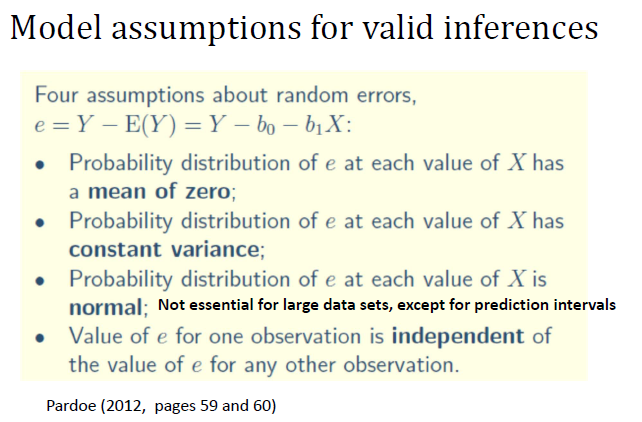

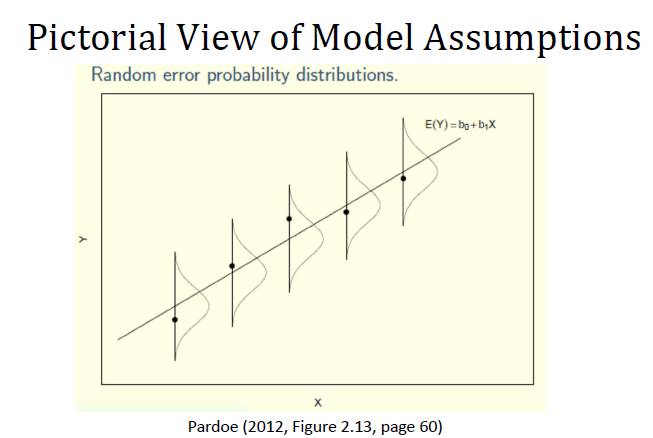

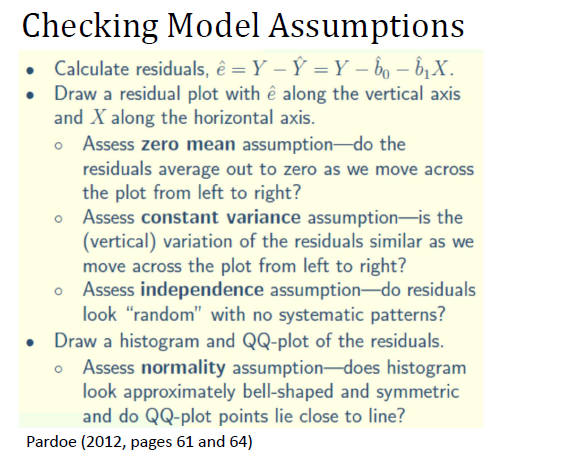

# Question 1: To what extent can the number of yards rushed per attempt, during the regular season in 2018, predicted the number of yards rushed per attempt in the 2019 footballl season?

### OLS on non transformed data

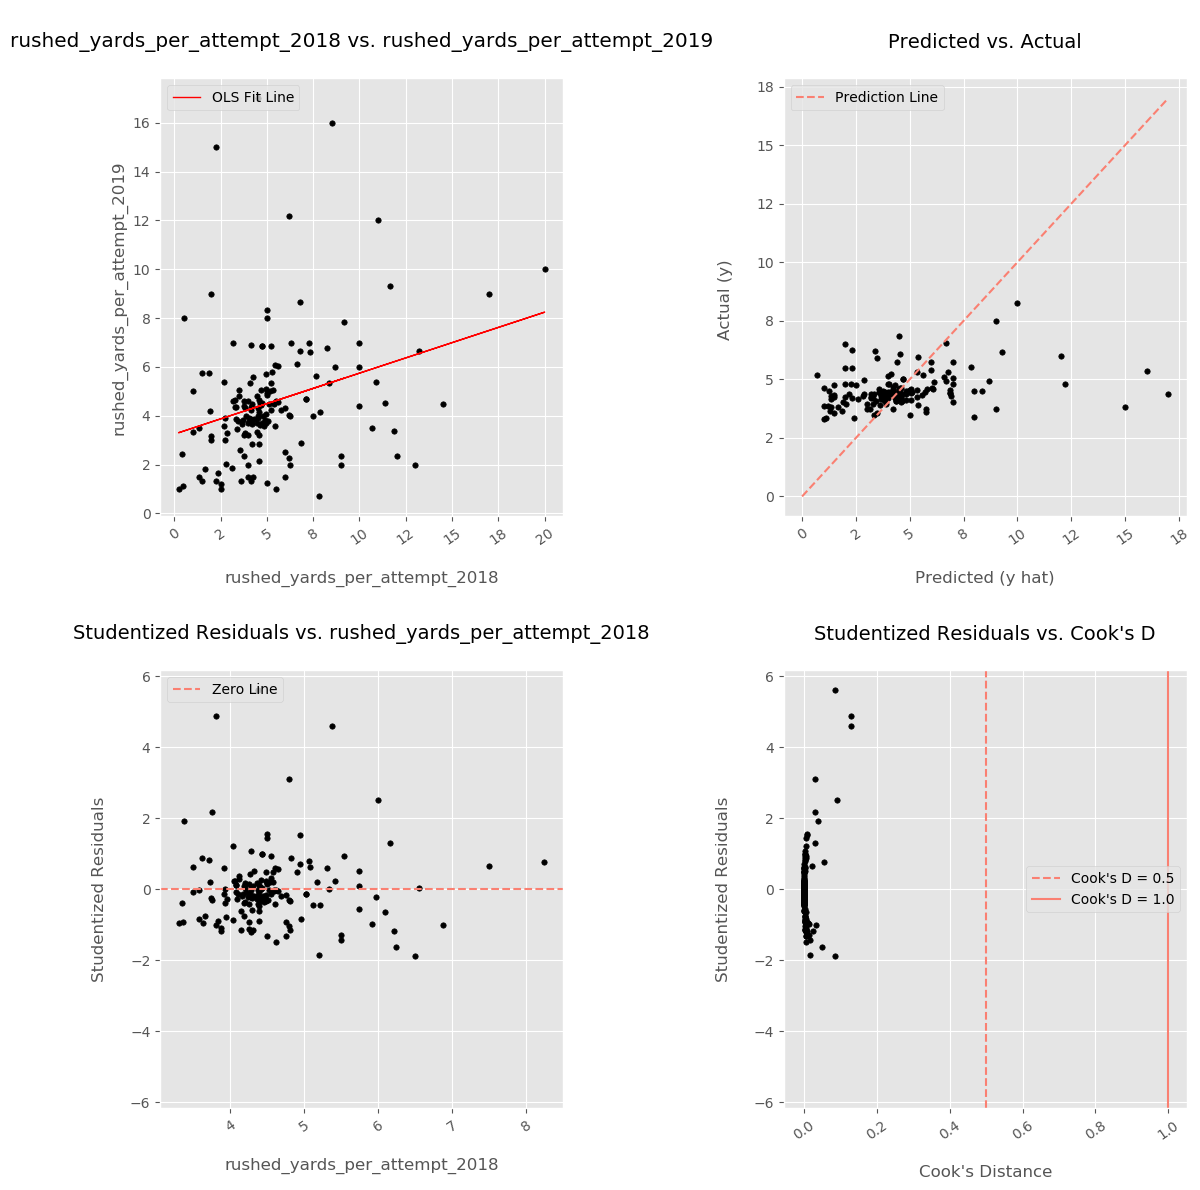



                                  OLS Regression Results                                 
Dep. Variable:     rushed_yards_per_attempt_2019   R-squared:                       0.087
Model:                                       OLS   Adj. R-squared:                  0.081
Method:                            Least Squares   F-statistic:                     15.18
Date:                           Fri, 02 Oct 2020   Prob (F-statistic):           0.000144
Time:                                   02:41:47   Log-Likelihood:                -374.91
No. Observations:                            162   AIC:                             753.8
Df Residuals:                                160   BIC:                             760.0
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]


In [17]:
combined['rushed_yards_per_attempt_2018'] = combined['Rush Yds_2018']/combined['Att_2018']
combined['rushed_yards_per_attempt_2019'] = combined['Rush Yds_2019']/combined['Att_2019']

x = combined['rushed_yards_per_attempt_2018'] 
y = combined['rushed_yards_per_attempt_2019']

df = binary_ols_regression(x, y, combined, add_constant = True)

### Check the residuals for normality

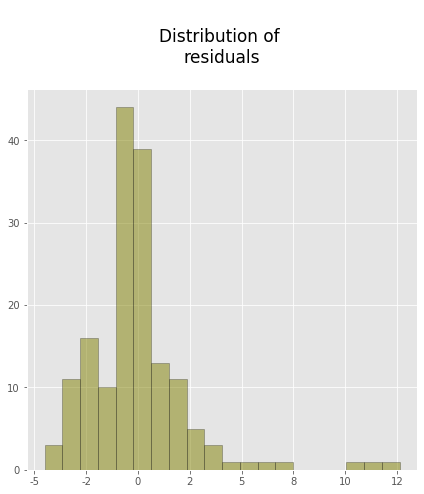

Statistics=93.495, p=0.000
Sample does not look Gaussian (reject H0)


In [18]:
normal_test(df['residuals'])

<b>There appears to be an issue with non-constant variance.  Let's try a log transformation. </b>

### OLS after log trasformation of both x and y variables

In [19]:
x = log_transform(combined['rushed_yards_per_attempt_2018'])
y = log_transform(combined['rushed_yards_per_attempt_2019'])

<b> Although normality is not necessary to fix non-constant-variance in the residual plots, it is good practice to test for it, for other model architectures down the line that require normalization.</b>

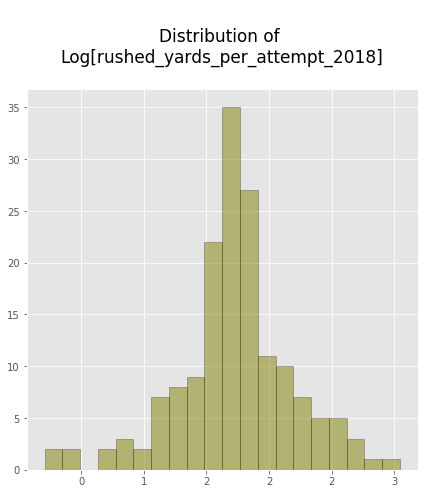

Statistics=9.899, p=0.007
Sample does not look Gaussian (reject H0)


In [20]:
normal_test(x)

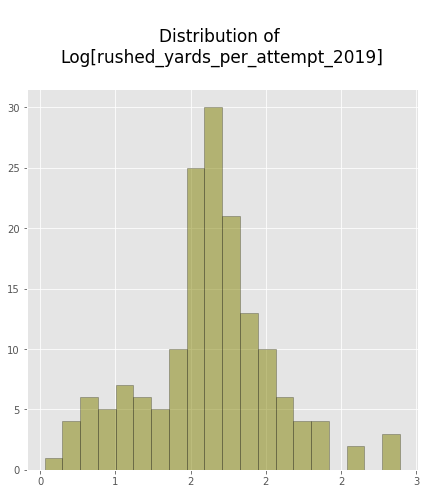

Statistics=2.996, p=0.224
Sample looks Gaussian (fail to reject H0)


In [21]:
normal_test(y)

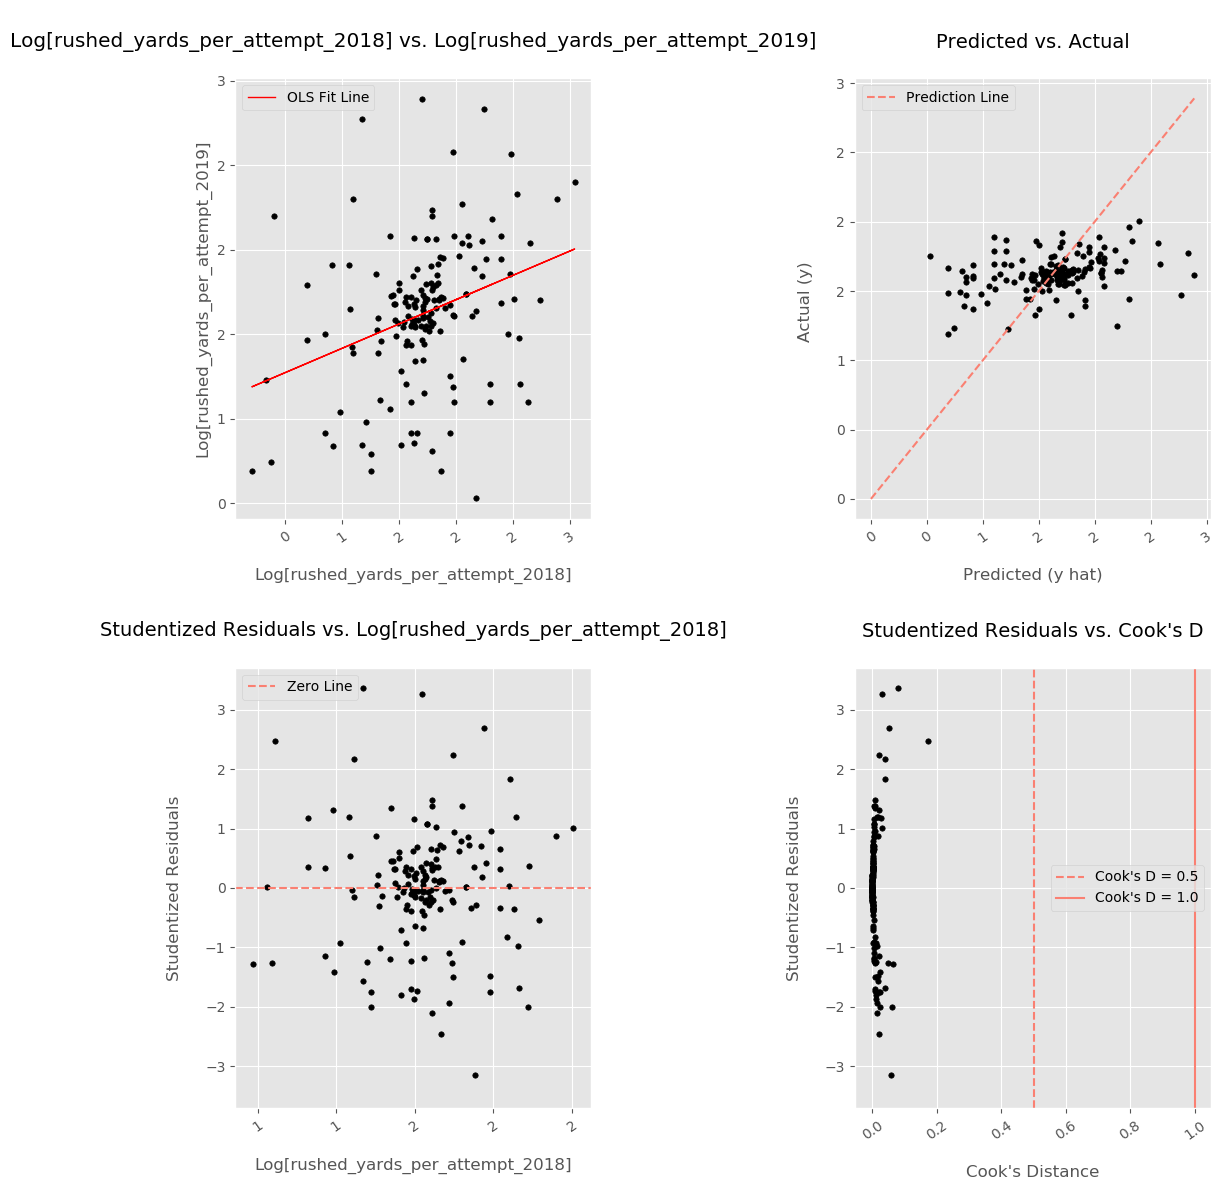



                                    OLS Regression Results                                    
Dep. Variable:     Log[rushed_yards_per_attempt_2019]   R-squared:                       0.101
Model:                                            OLS   Adj. R-squared:                  0.095
Method:                                 Least Squares   F-statistic:                     17.95
Date:                                Fri, 02 Oct 2020   Prob (F-statistic):           3.82e-05
Time:                                        02:41:50   Log-Likelihood:                -81.494
No. Observations:                                 162   AIC:                             167.0
Df Residuals:                                     160   BIC:                             173.2
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
                                         coef   

In [22]:
df = binary_ols_regression(x, y, combined, add_constant = True)

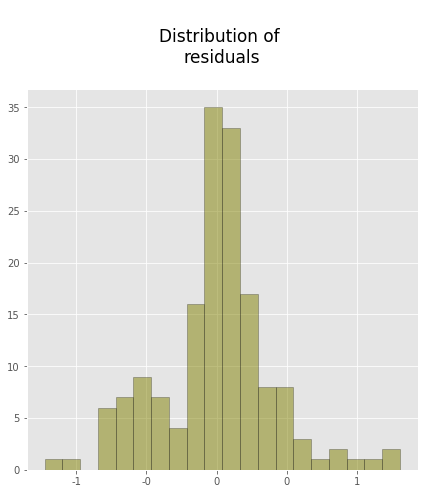

Statistics=6.296, p=0.043
Sample does not look Gaussian (reject H0)


In [23]:
normal_test(df['residuals'])

### Weighted Least Squares

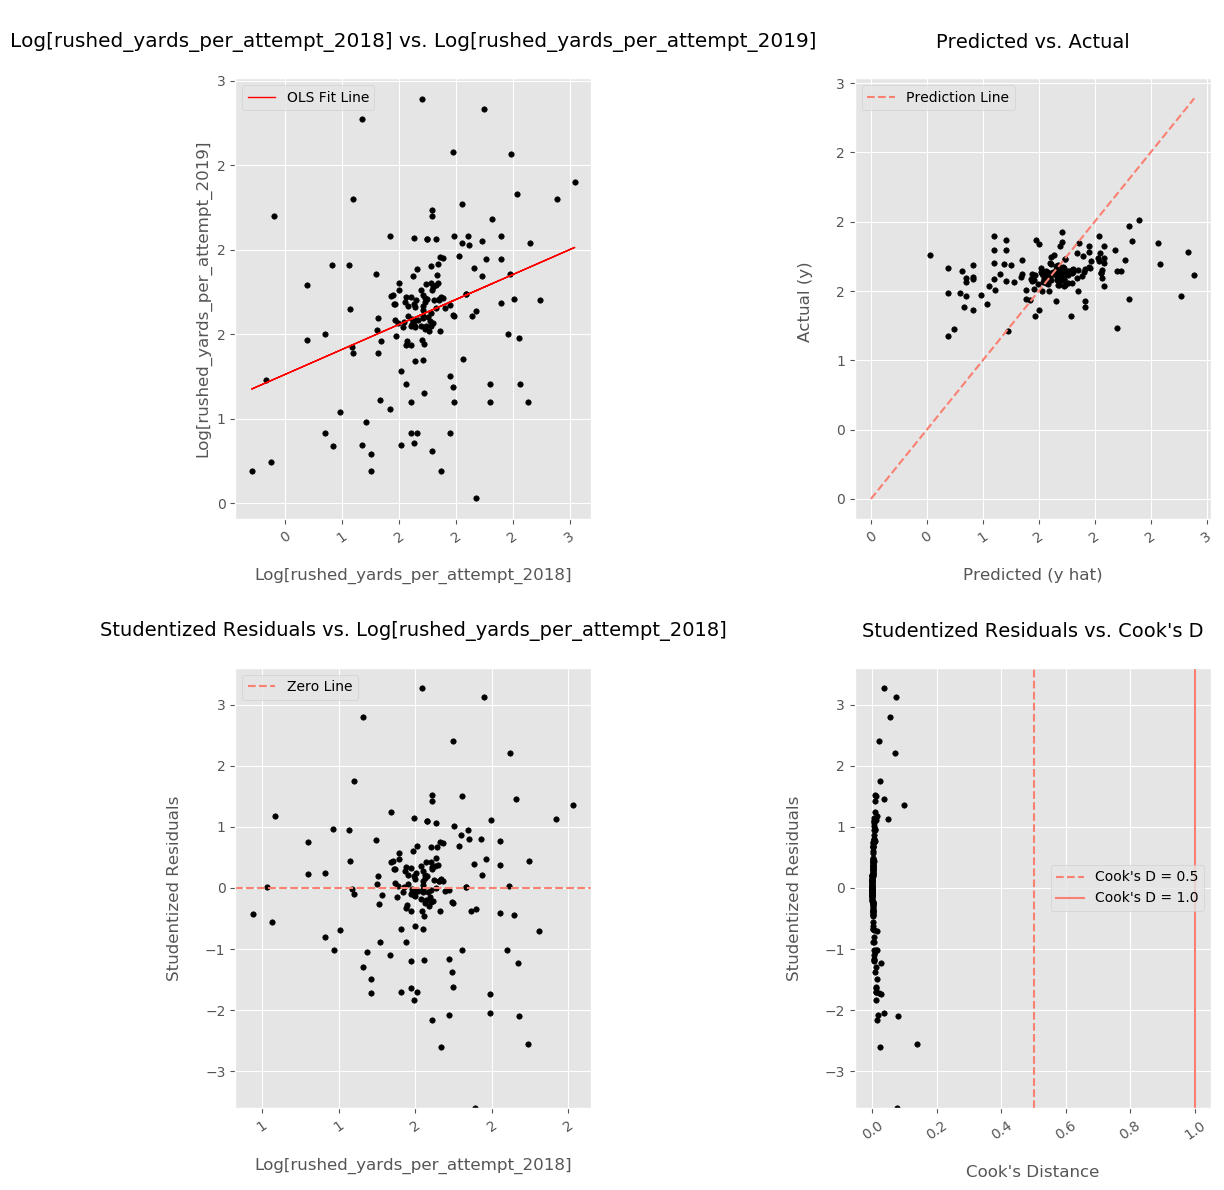



                                    WLS Regression Results                                    
Dep. Variable:     Log[rushed_yards_per_attempt_2019]   R-squared:                       0.091
Model:                                            WLS   Adj. R-squared:                  0.086
Method:                                 Least Squares   F-statistic:                     16.10
Date:                                Fri, 02 Oct 2020   Prob (F-statistic):           9.21e-05
Time:                                        02:41:52   Log-Likelihood:                -84.309
No. Observations:                                 162   AIC:                             172.6
Df Residuals:                                     160   BIC:                             178.8
Df Model:                                           1                                         
Covariance Type:                            nonrobust                                         
                                         coef   

,Player,Current Team,Position,Status,Log[rushed_yards_per_attempt_2019],Log[rushed_yards_per_attempt_2018],y,x,y_hat,residuals,studentized_residuals,h,cooks_distance
0,Tavon Austin,San Francisco 49ers,WR,RES,2.178532,2.319114,2.178532,2.319114,1.799070,0.379462,1.113849,0.018432,0.011631
1,Alex Armah,Carolina Panthers,FB,ACT,1.041454,0.980829,1.041454,0.980829,1.404191,-0.362738,-0.690661,0.018052,0.004399
2,Kyle Allen,Washington Football Team,QB,ACT,1.461518,1.568616,1.461518,1.568616,1.577626,-0.116108,-0.277810,0.008040,0.000315
3,Keenan Allen,Los Angeles Chargers,WR,ACT,1.845827,2.233592,1.845827,2.233592,1.773836,0.071991,0.206198,0.014533,0.000315
4,Josh Allen,Buffalo Bills,QB,ACT,1.736757,2.090615,1.736757,2.090615,1.731649,0.005109,0.014122,0.009909,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Mike Williams,Los Angeles Chargers,WR,ACT,1.098612,1.609438,1.098612,1.609438,1.589671,-0.491059,-1.194904,0.007579,0.005437
158,James White,New England Patriots,RB,ACT,1.594400,1.708609,1.594400,1.708609,1.618933,-0.024533,-0.061209,0.006782,0.000013
159,Dede Westbrook,Jacksonville Jaguars,WR,ACT,1.856298,2.475604,1.856298,2.475604,1.845245,0.011053,0.033556,0.028052,0.000016
160,Carson Wentz,Philadelphia Eagles,QB,ACT,1.593177,1.317827,1.593177,1.317827,1.503627,0.089550,0.196764,0.012028,0.000237


In [24]:
x = log_transform(combined['rushed_yards_per_attempt_2018'])
y = log_transform(combined['rushed_yards_per_attempt_2019'])
w = log_transform(combined['rushed_yards_per_attempt_2018'])

binary_wls_regression(x, y, w, combined)

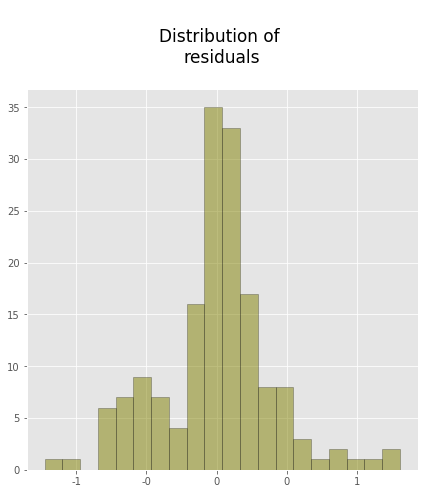

Statistics=6.296, p=0.043
Sample does not look Gaussian (reject H0)


In [25]:
normal_test(df['residuals'])

### Additional Visual Inspection Shows That 2018 is not predictive.

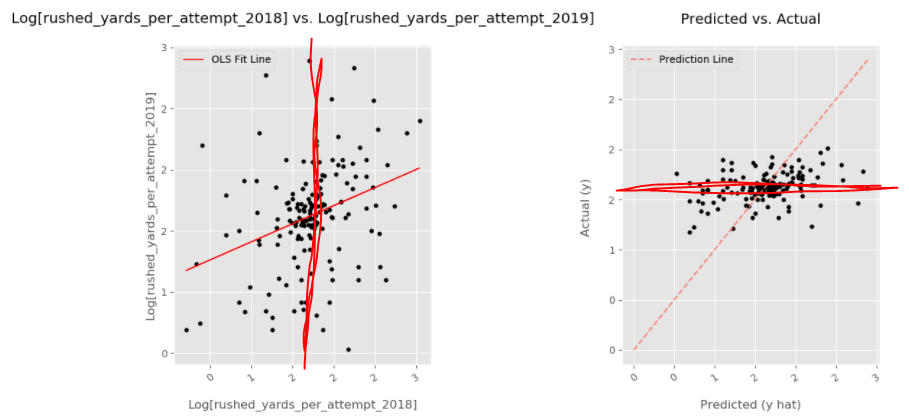

## At this time, we can't conclude that rushing yards per attempt, during the 2018 regular season, predicts the number of rushing yards rushed per attempt in the 2019 season.
- The predicted vs. actual plots a wide range of predictions for similar values of y
- An R^2 of 0.1 shows that the variance of y can only be explained by 10% of the variance in x.
- In addition, although the data set is large, the model technically violates the 3th assumption that the residuals need to be normally distributed.

# Question 2: To what extent can the total number of yards rushed by each player in 2019 be predicted by the total number of yards they rushed in 2018?

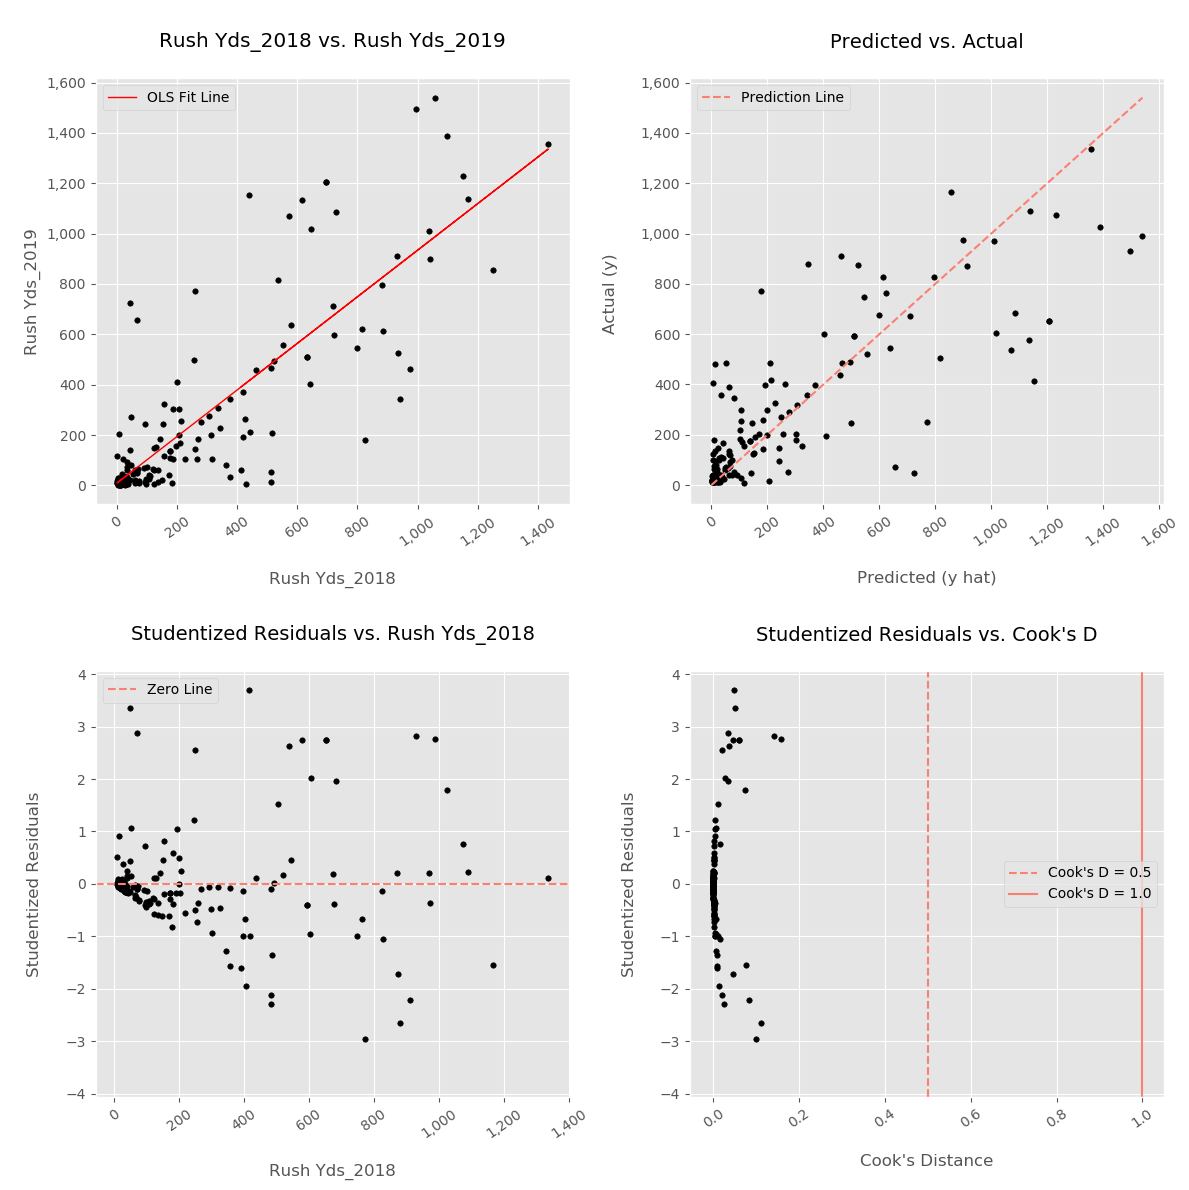



                            OLS Regression Results                            
Dep. Variable:          Rush Yds_2019   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     346.7
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           6.77e-42
Time:                        08:49:29   Log-Likelihood:                -1093.5
No. Observations:                 162   AIC:                             2191.
Df Residuals:                     160   BIC:                             2197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.8394     21.322      0.4

In [29]:
x = combined['Rush Yds_2018'] 
y = combined['Rush Yds_2019']

df = binary_ols_regression(x, y, combined, add_constant = True)

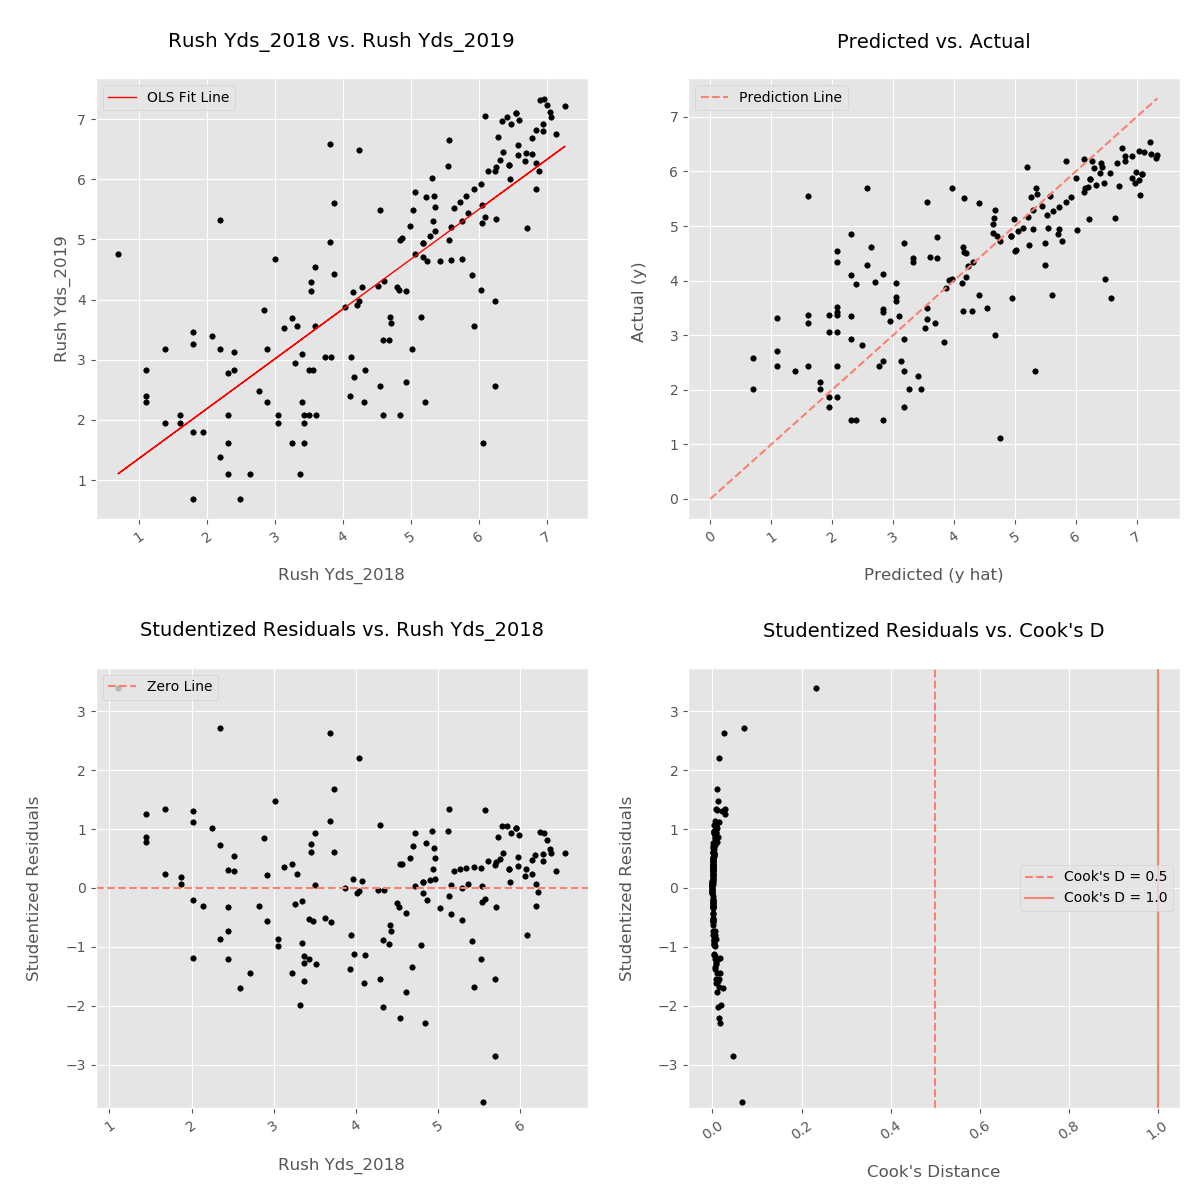



                            OLS Regression Results                            
Dep. Variable:          Rush Yds_2019   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     237.9
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           1.80e-33
Time:                        09:45:18   Log-Likelihood:                -248.87
No. Observations:                 162   AIC:                             501.7
Df Residuals:                     160   BIC:                             507.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5340      0.264      2.0

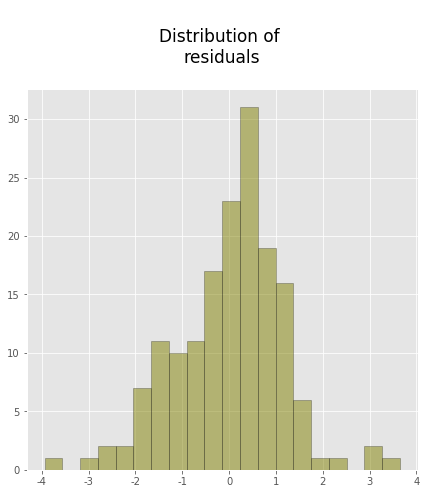

Statistics=7.398, p=0.025
Sample does not look Gaussian (reject H0)


In [100]:
x = np.log1p(combined['Rush Yds_2018']) 
y = np.log1p(combined['Rush Yds_2019'])

df = binary_ols_regression(x, y, combined, add_constant = True)
normal_test(df['residuals'])

# Question 3:  To what extent can the number of yards rushed by a player in 2018 during the regular season be predicted by the number of attempts in 2018? 

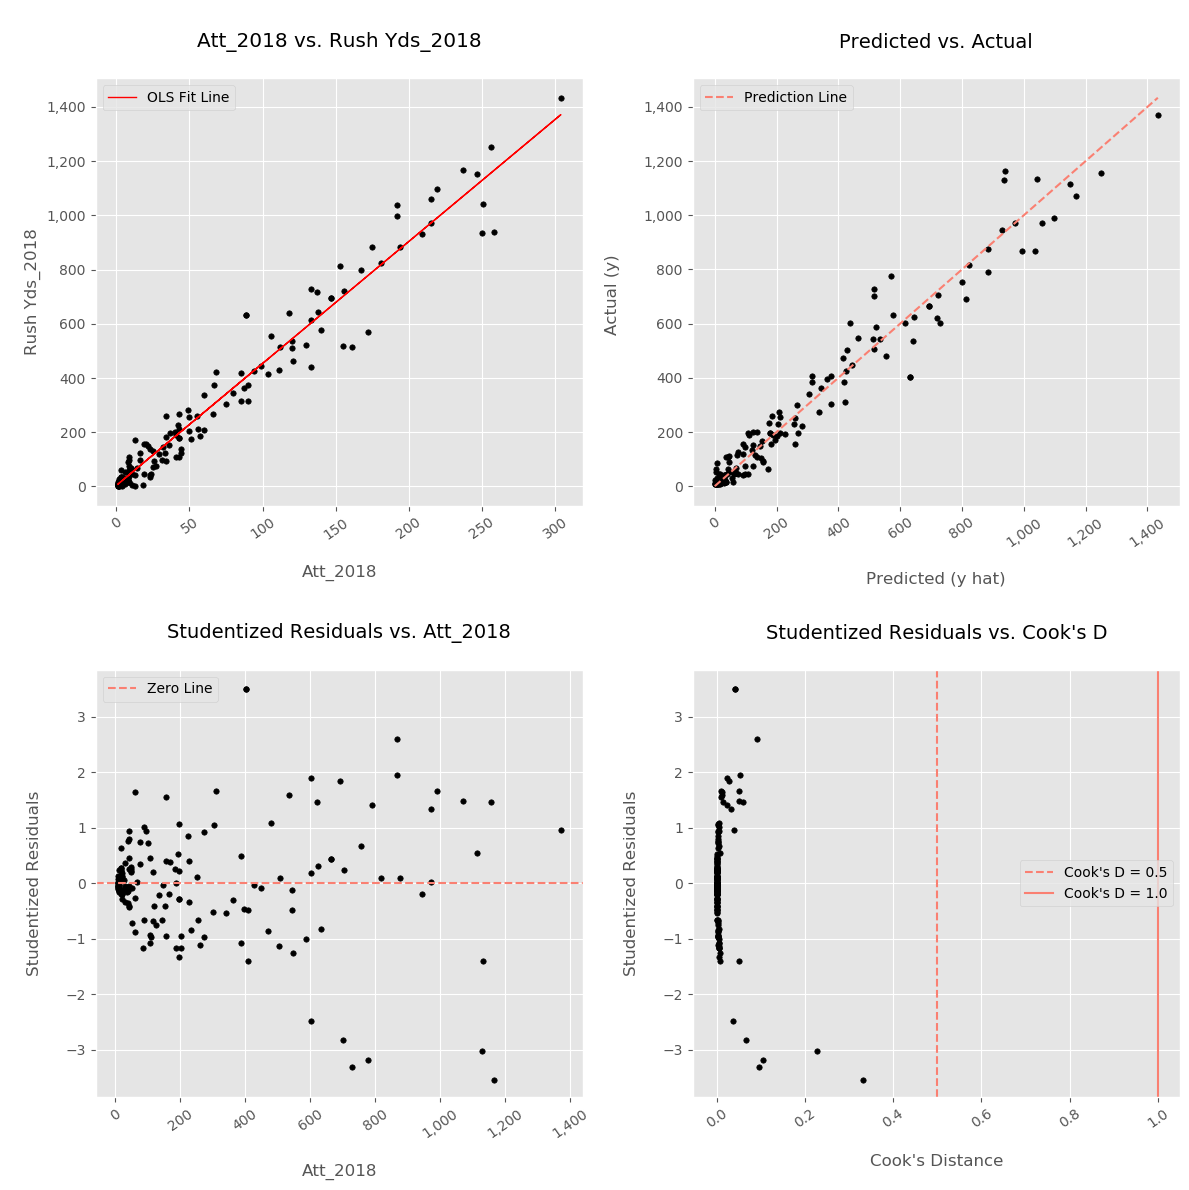



                            OLS Regression Results                            
Dep. Variable:          Rush Yds_2018   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     3699.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          1.67e-112
Time:                        09:39:30   Log-Likelihood:                -910.85
No. Observations:                 162   AIC:                             1826.
Df Residuals:                     160   BIC:                             1832.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4566      6.930      0.499      0

In [92]:
x = combined['Att_2018'] 
y = combined['Rush Yds_2018']

df = binary_ols_regression(x, y, combined, add_constant = True)

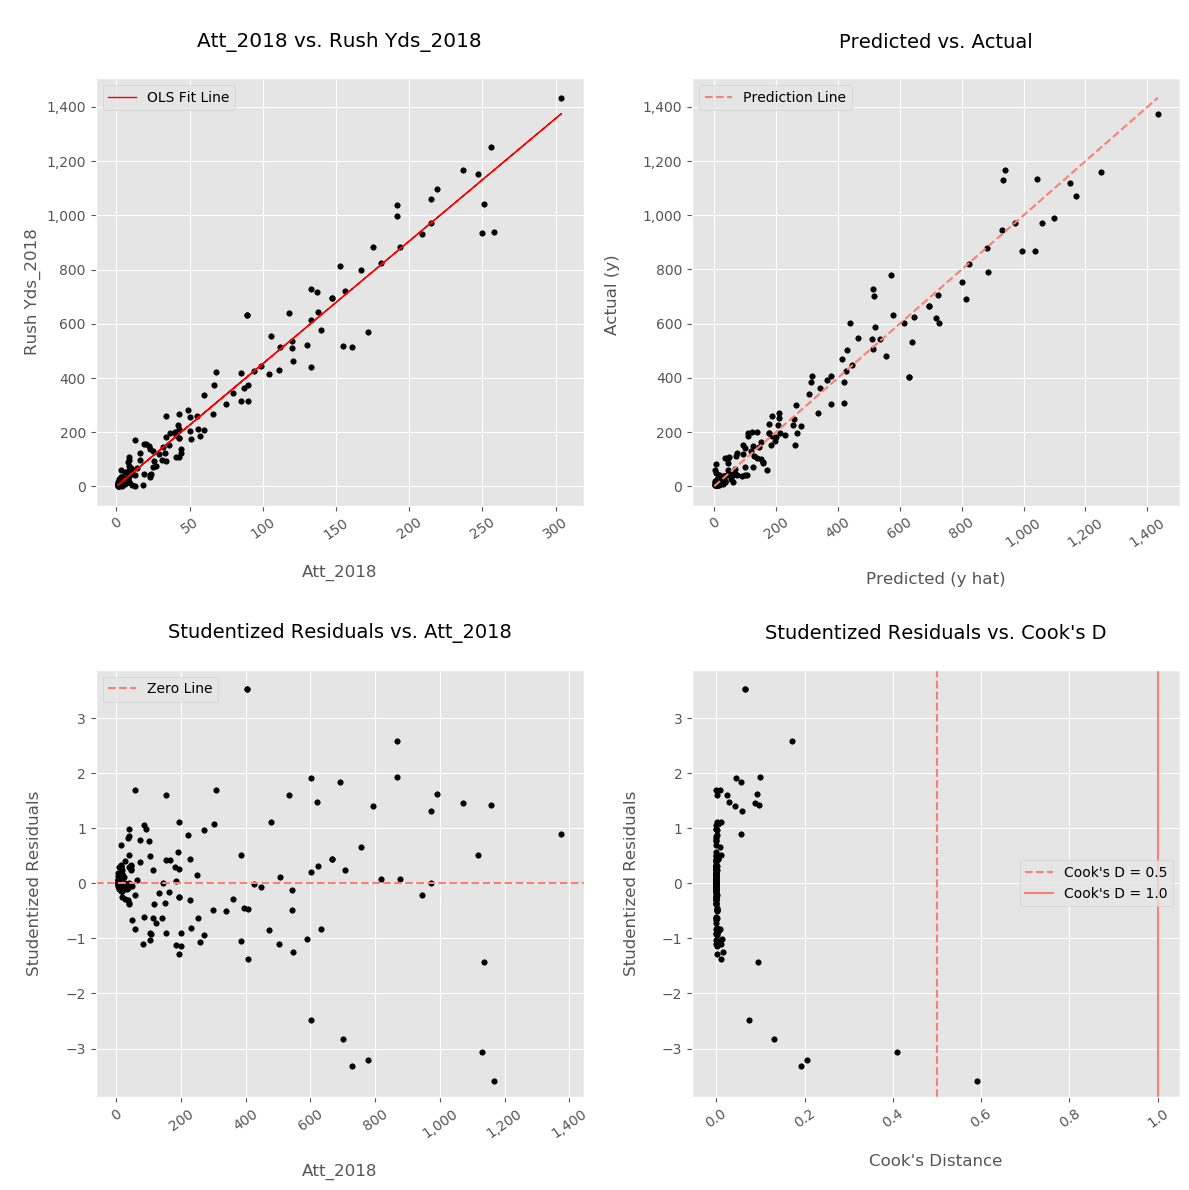



                                 OLS Regression Results                                
Dep. Variable:          Rush Yds_2018   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              6443.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):                   9.08e-132
Time:                        09:50:27   Log-Likelihood:                         -910.98
No. Observations:                 162   AIC:                                      1824.
Df Residuals:                     161   BIC:                                      1827.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

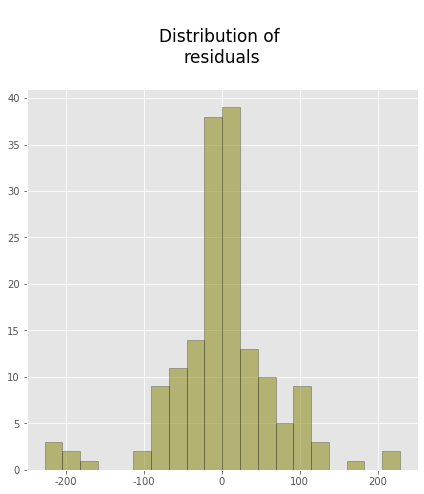

Statistics=17.455, p=0.000
Sample does not look Gaussian (reject H0)


In [106]:
x = combined['Att_2018'] 
y = combined['Rush Yds_2018']

df = binary_ols_regression(x, y, combined, add_constant = False)
normal_test(df['residuals'])

### Square Root Transform

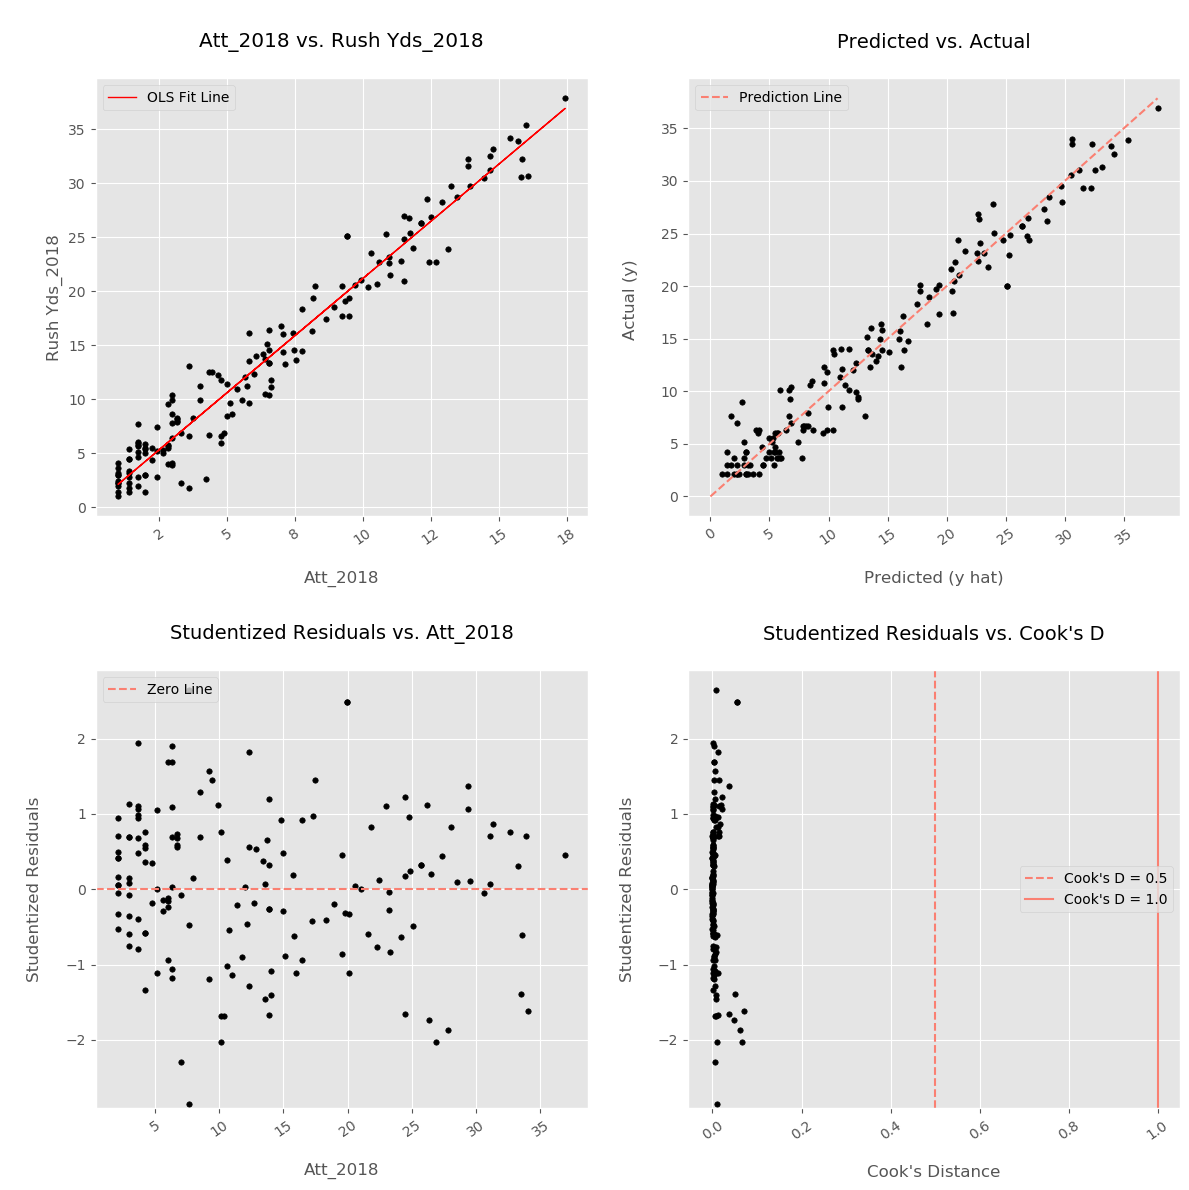



                                 OLS Regression Results                                
Dep. Variable:          Rush Yds_2018   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              9855.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):                   2.48e-146
Time:                        09:50:34   Log-Likelihood:                         -350.45
No. Observations:                 162   AIC:                                      702.9
Df Residuals:                     161   BIC:                                      706.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

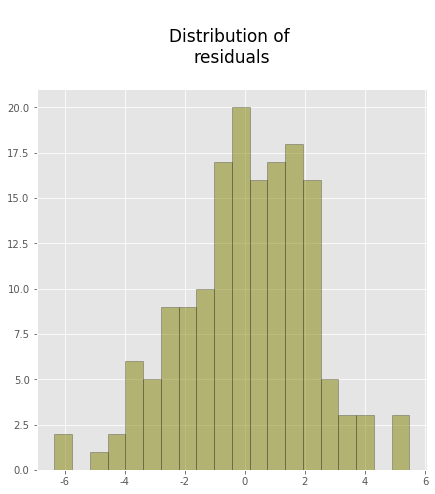

Statistics=2.626, p=0.269
Sample looks Gaussian (fail to reject H0)


In [107]:
x = combined['Att_2018']**0.5 
y = combined['Rush Yds_2018']**0.5

df = binary_ols_regression(x, y, combined, add_constant = False)
normal_test(df['residuals'])

### We have a valid model showing that attempts predict rushing in 2018

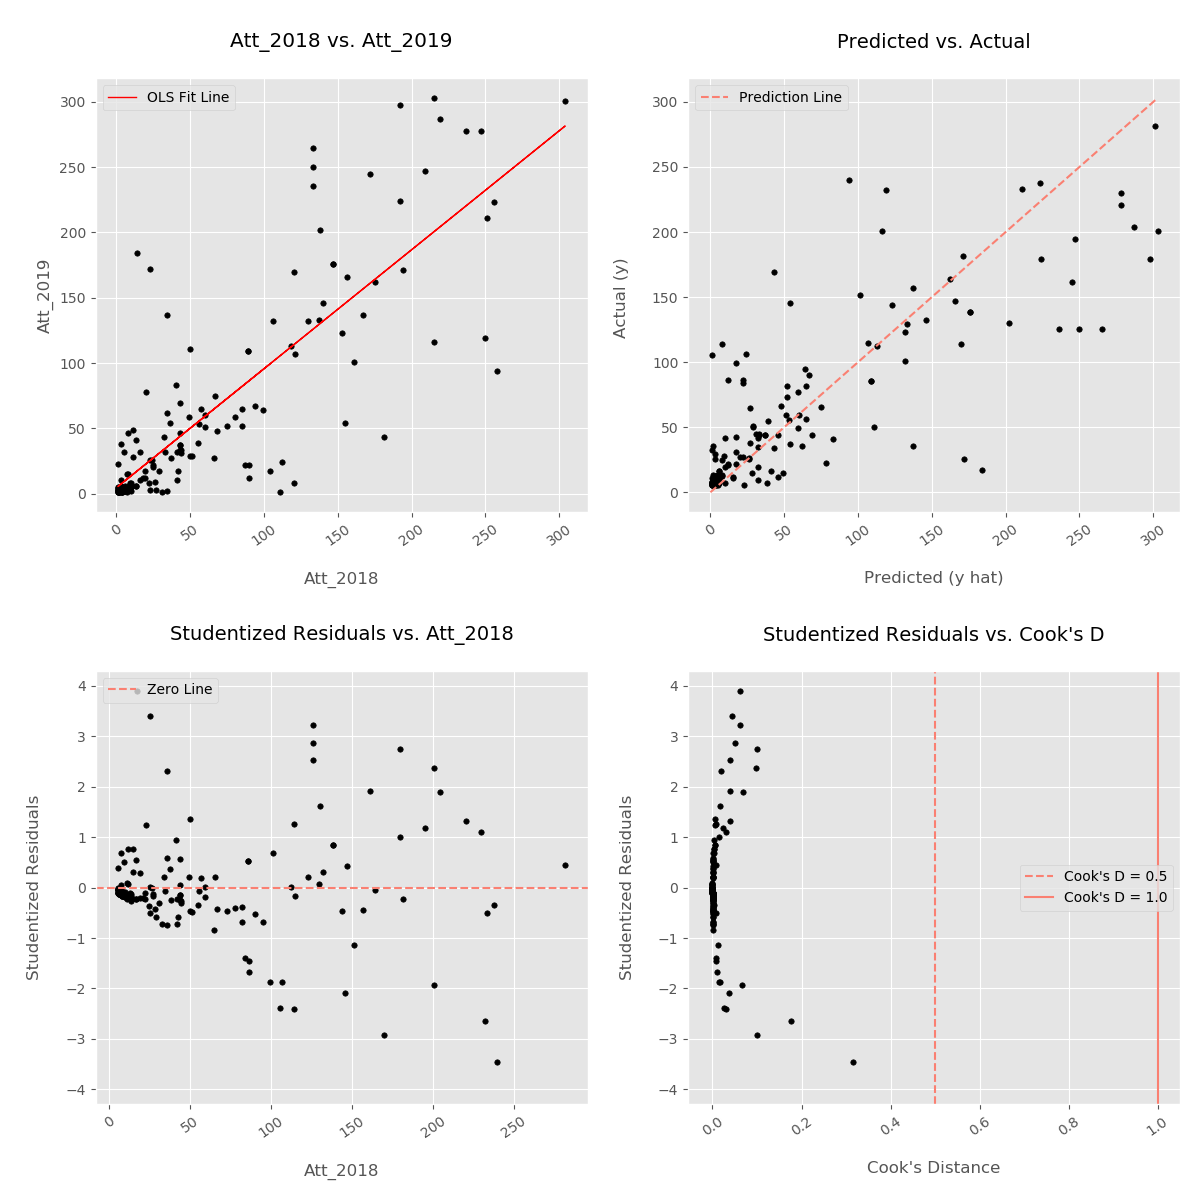



                            OLS Regression Results                            
Dep. Variable:               Att_2019   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     344.2
Date:                Fri, 02 Oct 2020   Prob (F-statistic):           9.98e-42
Time:                        10:35:06   Log-Likelihood:                -844.48
No. Observations:                 162   AIC:                             1693.
Df Residuals:                     160   BIC:                             1699.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5086      4.601      0.980      0

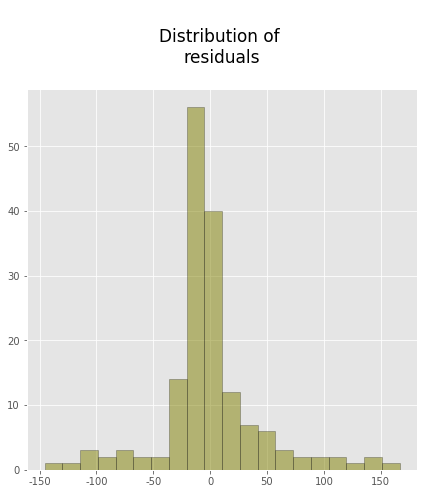

Statistics=26.160, p=0.000
Sample does not look Gaussian (reject H0)


In [124]:
x = combined['Att_2018']
y = combined['Att_2019']

df = binary_ols_regression(x, y, combined, add_constant = True)
normal_test(df['residuals'])

In [123]:
combined

,Player,Current Team,Position,Status,Rush Yds_2018,Att_2018,TD_2018,20+_2018,40+_2018,Lng_2018,...,Att_2019,TD_2019,20+_2019,40+_2019,Lng_2019,Rush 1st_2019,Rush 1st%_2019,Rush FUM_2019,rushed_yards_per_attempt_2018,rushed_yards_per_attempt_2019
0,Tavon Austin,San Francisco 49ers,WR,RES,55,6,0,0,0,18,...,6,1,1,0,20,2,3.000,1,9.166667,7.833333
1,Alex Armah,Carolina Panthers,FB,ACT,15,9,2,0,0,4,...,6,1,0,0,4,1,6.000,0,1.666667,1.833333
2,Kyle Allen,Washington Football Team,QB,ACT,19,5,1,0,0,10,...,32,2,0,0,17,9,3.556,3,3.800000,3.312500
3,Keenan Allen,Los Angeles Chargers,WR,ACT,75,9,0,2,0,28,...,3,0,0,0,18,1,3.000,0,8.333333,5.333333
4,Josh Allen,Buffalo Bills,QB,ACT,631,89,8,8,1,45,...,109,9,1,0,36,41,2.659,7,7.089888,4.678899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,Mike Williams,Los Angeles Chargers,WR,ACT,28,7,1,0,0,19,...,1,0,0,0,2,0,0.000,0,4.000000,2.000000
158,James White,New England Patriots,RB,ACT,425,94,5,5,0,27,...,67,1,1,0,32,15,4.467,0,4.521277,3.925373
159,Dede Westbrook,Jacksonville Jaguars,WR,ACT,98,9,0,2,1,43,...,5,0,0,0,8,0,0.000,0,10.888889,5.400000
160,Carson Wentz,Philadelphia Eagles,QB,ACT,93,34,0,0,0,13,...,62,1,0,0,19,21,2.952,6,2.735294,3.919355


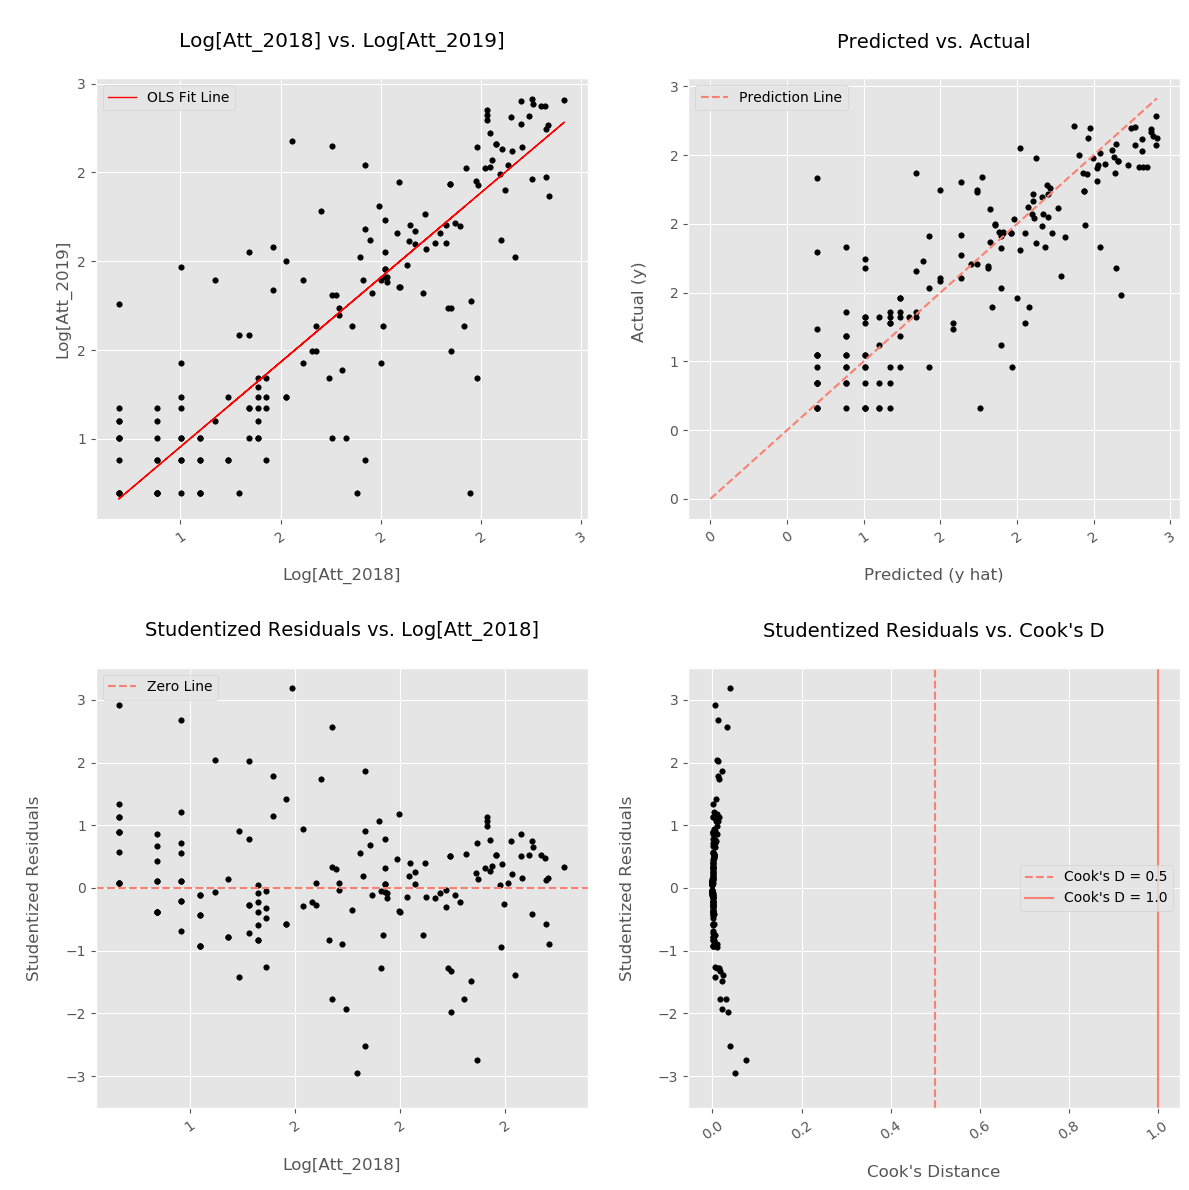



                                 OLS Regression Results                                
Dep. Variable:          Log[Att_2019]   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              3653.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):                   1.42e-112
Time:                        13:11:35   Log-Likelihood:                         -74.598
No. Observations:                 162   AIC:                                      151.2
Df Residuals:                     161   BIC:                                      154.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

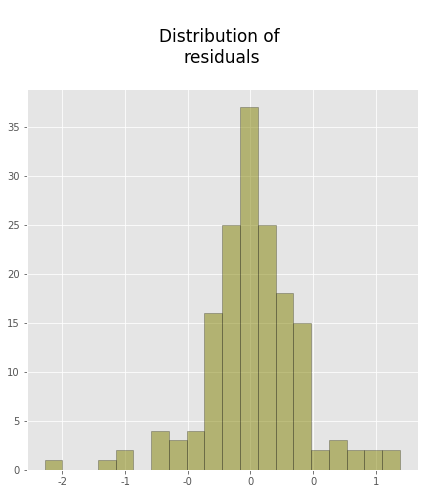

Statistics=19.344, p=0.000
Sample does not look Gaussian (reject H0)


In [128]:
x = log_transform(combined['Att_2018']**0.5)
y = log_transform(combined['Att_2019']**0.5)

df = binary_ols_regression(x, y, combined, add_constant = False)
normal_test(df['residuals'])